In [974]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pickle
import pandas as pd
import os
import math
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

<h2>Подготовка данных </h2>

In [975]:
# Данные можно скачать по ссылке: https://www.kaggle.com/datasets/rajyellow46/wine-quality
file_path = "winequalityN.csv"
data = pd.read_csv(file_path, parse_dates=True)
mix_data = data.sample(frac=1).reset_index(drop=True)

In [976]:
names = ['type', 'fixed acidity','volatile acidity', 'citric acid',	'residual sugar', 'chlorides',	'free sulfur dioxide',	'total sulfur dioxide',	'density',	'pH', 'sulphates',	'alcohol', 'quality']
colors = ['#9932CCAF', '#98F5FFAF', '#FFD39BAF', '#8B2323AF', '#FF4040AF', '#0000FFAF', '#E3CF57AF', '#00FFFFAF', '#FF1493AF', '#228B22AF', '#7FFF00AF', '#8B0A50AF', '#5D478BAF']

data_without_miss = mix_data.dropna()
mix_data = data_without_miss

При анализе данных было выяснено, что присутствуют выбросы, их необходимо удалить:

In [977]:
data_IQR = mix_data
for i in range(1, len(names) - 1):
    qv1 =  mix_data[names[i]].quantile(0.2)
    qv2 = mix_data[names[i]].quantile(0.8)
    between = qv2 - qv1
    data_IQR = data_IQR.loc[(mix_data[names[i]] > (qv1 - 1.5 * between)) & (mix_data[names[i]] < (qv2 + 1.5 * between))]
data = data_IQR

Удалим данные, мало влияющие на результат:

In [978]:
# data1 = data.drop(columns=["pH", "sulphates", "free sulfur dioxide", "total sulfur dioxide", "residual sugar", "citric acid", "fixed acidity", "density"])
# names = ['type', 'fixed acidity','volatile acidity', 'citric acid',	'residual sugar', 'chlorides',	'free sulfur dioxide',	'total sulfur dioxide',	'density',	'pH', 'sulphates',	'alcohol', 'quality']
data1 = data.drop(columns=["pH","residual sugar", "total sulfur dioxide", "free sulfur dioxide", "sulphates"])

In [979]:
cond01 = data1['quality'] == 3
cond02 = data1['quality'] == 4
cond03 = data1['quality'] == 5

cond12 = data1['quality'] == 6

cond21 = data1['quality'] == 7
cond22 = data1['quality'] == 8
cond23 = data1['quality'] == 9

data1.loc[cond01, 'quality'] = 0
data1.loc[cond02, 'quality'] = 0
data1.loc[cond03, 'quality'] = 0

data1.loc[cond12, 'quality'] = 1

data1.loc[cond21, 'quality'] = 2
data1.loc[cond22, 'quality'] = 2
data1.loc[cond23, 'quality'] = 2


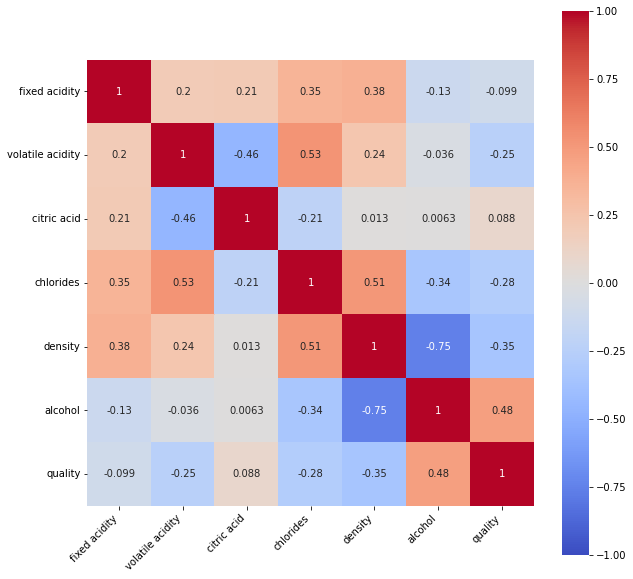

In [980]:
corr = data1.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, cmap= 'coolwarm', square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.show()

Разделим данные на тренирвочные и тестовые:

In [981]:
df_train = data1[0: len(data1) * 8 // 10]
df_test = data1[0: len(data1) * 2 // 10]

label_train = df_train['quality'].to_numpy()
label_test = df_test['quality'].to_numpy()

In [982]:
data_train = df_train.drop(columns=['quality']).to_numpy()[:,1:]
data_test = df_test.drop(columns=['quality']).to_numpy()[:,1:]

data_train.astype(np.float32)
data_test.astype(np.float32)
label_train.astype(np.float32)
label_test.astype(np.float32)
len(data_train)

4665

Так как в ходе реализацией точность некоторых алгоритмов для разделения на больше чем два класса была очень низкой, попробуем насильно разделить данные на два отличающихся класса:

In [983]:
data2 = data1.drop(data1[data1['quality'] == 1].index)
cond = data2['quality'] == 2
data2.loc[cond, 'quality'] = 1

df_train = data2[0: len(data1) * 8 // 10]
df_test = data2[0: len(data1) * 2 // 10]

label_train2 = df_train['quality'].to_numpy()
label_test2 = df_test['quality'].to_numpy()

data_train2 = df_train.drop(columns=['quality']).to_numpy()[:,1:]
data_test2 = df_test.drop(columns=['quality']).to_numpy()[:,1:]

data_train2.astype(np.float32)
data_test2.astype(np.float32)
label_train2.astype(np.float32)
label_test2.astype(np.float32)
len(data_train2)

3276

Вспомогательные функции:

In [984]:
from sklearn import metrics
def plot_ConfusionMatrix(y_true, y_pred, title = ""):
    c_matr = metrics.confusion_matrix(y_true, y_pred) 
    disp = metrics.ConfusionMatrixDisplay(c_matr)
    fig, ax = plt.subplots(figsize=(10,10));
    disp.plot(ax=ax);
    disp.ax_.set_title("ConfusionMatrix " + title);

<h2> Logistic Regression (Multiclass) </h2>

In [985]:
def one_hot(x):
    oh = []
    for i in x:
        if i == 0:
            oh.append([1.0, 0, 0])
        elif i == 1:
            oh.append([0, 1.0, 0])
        else:
            oh.append([0, 0, 1.0]) 
    return oh

class CrossEntropyLoss:
    def Loss(self, probabilities, trueVal):
        self.p = probabilities;
        self.trueVal = trueVal
        self.size = len(self.trueVal)
        self.loss = [-np.log(probabilities[i, trueVal[i]]) for i in range(self.size)]
        return self.loss
    def Back(self):
        delta = np.zeros_like(self.p)
        delta[np.arange(self.size), self.trueVal] = 1.0
        return delta / (self.p * -self.size)

class Softmax:
    def Next(self, z):
        self.z = z
        e = np.exp(z - z.max(axis=1,keepdims=True))
        sum = e.sum(axis=1,keepdims=True)
        self.p = e / sum
        return self.p
    def Back(self, dp):
        back_z = self.p
        return self.p * dp - self.p * (self.p * dp).sum(axis=1, keepdims=True)

class LogisticRegressionMulti(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size, countClasses):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.softmax = Softmax()
        self.loss = CrossEntropyLoss()
        self.countClasses = countClasses

    def Forward(self, x):
        self.data = x
        p = np.dot(self.data, self.W) + self.b
        return self.softmax.Next(p.astype(np.float64))
    
    def Update(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db
        
    def fit(self, data, labels): 
        self.W = np.random.normal(0.1, 1.0 / np.sqrt(len(data[0])), (len(data[0]), self.countClasses))
        self.b = np.zeros((1, self.countClasses))

        for _ in range(self.epoch):
            for i in range(0, len(data), self.batch_size):
                x = data[i:i + self.batch_size]
                y = labels[i:i + self.batch_size]
                
                y_hat = self.Forward(x.astype(np.float64))
                
                self.loss.Loss(y_hat, y)

                dp = self.loss.Back()
                dz = self.softmax.Back(dp)

                self.dW = np.dot(dz.T, self.data).T
                self.db = dz.sum(axis = 0)
                self.Update()
        
    def predict(self, data):
        p = self.Forward(data)
        return np.argmax(p, axis = 1)

    def pred_proba(self, data):
        return self.Forward(data)

class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def Forward(self, x):
        self.data = x
        p = np.dot(self.W, self.data.T)
        return self.sigmoid(p.astype(np.float64))
    
    def Update(self):
        self.W -= self.lr * self.dW
        
    def fit(self, data, labels): 
        self.W = np.random.normal(0.1, 1.0 / np.sqrt(len(data[0])), (len(data[0]), ))

        for _ in range(self.epoch):
            for i in range(0, len(data), self.batch_size):
                x = data[i:i + self.batch_size]
                y = labels[i:i + self.batch_size]
                
                y_hat = self.Forward(x.astype(np.float64))

                self.dW = self.W + np.dot(y_hat - y, x)
                self.dW = self.dW.astype('float64')
                self.Update()
        
    def predict(self, data):
        p = self.Forward(data)
        return (p  > 0.5).astype('int64')
    
    def pred_proba(self, data):
        return self.Forward(data)

<h2> SVM (Multiclass)</h2>

In [986]:
def convert(data, cond):
    x = data
    if cond == 1:
        x = np.where(x == 1, -1, x)
        x = np.where(x == 0, 1, x)
        x = np.where(x == 2, -1, x)
    elif cond == 2:
        x = np.where(x == 0, -1, x)
        x = np.where(x == 1, 1, x)
        x = np.where(x == 2, -1, x)
    else:
        x = np.where(x == 0, -1, x)
        x = np.where(x == 1, -1, x)
        x = np.where(x == 2, 1, x)
    return x.astype(np.int64)

def convert1(data):
    x = data
    x = np.where(x == 0, -1, x)
    return x.astype(np.int64)

class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size, alph):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.alph = alph
    
    def Forward(self, x):
        p = np.dot(x, self.W)
        return p

    def fit(self, data, labels):
        self.W = np.ones((len(data[0]),))  

        for _ in range(self.epoch):
            for i in range(0, len(data), self.batch_size):
                x = data[i:i + self.batch_size]
                y = labels[i:i + self.batch_size]

                p = self.Forward(x)

                dp = self.alph * self.W

                for i, p_i in enumerate(p):
                    m = p_i * y[i]
                    if 1 - m > 0:
                        dp -= (x[i] * y[i]).astype(np.float64)
                        
                self.W -= self.lr * dp
        
    def predict(self, data):
        p = self.Forward(data)
        return np.sign(p).astype(np.int64)
    
    def pred_proba(self, data):
        p = self.Forward(data)
        return p

class SVM_Multi(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size, alph):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.alph = alph

    def Forward(self, x):
        p = np.asarray([self.svm1.predict(x), self.svm2.predict(x), self.svm3.predict(x)]).T
        return p
    
    def Forward_pr(self, x):
        p = np.asarray([self.svm1.pred_proba(x), self.svm2.pred_proba(x), self.svm3.pred_proba(x)]).T
        return p

    def fit(self, data, labels):
        self.svm1 = SVM(self.lr, self.epoch, self.batch_size, self.alph)
        self.svm2 = SVM(self.lr, self.epoch, self.batch_size, self.alph)
        self.svm3 = SVM(self.lr, self.epoch, self.batch_size, self.alph)

        l1 = convert(labels, 1)
        l2 = convert(labels, 2)
        l3 = convert(labels, 3)

        self.svm1.fit(data, l1)
        self.svm2.fit(data, l2)
        self.svm3.fit(data, l3)

        # acc1 = int((self.svm1.predict(data)==l1).mean() * 100)
        # acc2 = int((self.svm2.predict(data)==l2).mean() * 100)
        # acc3 = int((self.svm3.predict(data)==l3).mean() * 100)
        
        # print("acc_train svm1:" + str(acc1) + "%")
        # print("acc_train svm2:" + str(acc2) + "%")
        # print("acc_train svm3:" + str(acc3) + "%")
        
    def predict(self, data):
        p = self.Forward(data)
        rez = []
        for p_i in p:
            if p_i.tolist() == [1, 1, 1]:
                rez.append(2)
            elif p_i.tolist() == [1, 1, -1]:
                rez.append(1)
            elif p_i.tolist() == [-1, 1, 1]:
                rez.append(1)
            else:
                rez.append(np.argmax(p_i))
        return rez
    
    def pred_proba(self, data):
        p = self.Forward(data)
        

<h2>KNN </h2>

In [987]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k, countClasses):
        self.k = k
        self.countClasses = countClasses   
    
    def dist (self, a, b):
        return math.sqrt(np.sum(np.power(a - b, 2)))
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        
    def predict(self, data):
        predLables = []
        
        for i, d_i in enumerate(data):
            distance = list()
            for j, d_j in enumerate(self.data):
                distance.append([self.dist(d_j, d_i), self.labels[j]])

            stat_classes = np.zeros(self.countClasses)
            sort_dist = sorted(distance)
            for d in sort_dist[0:self.k]:
                stat_classes[d[1]] += 1
            
            predLables.append(np.argmax(stat_classes))

        return predLables        

    def pred_proba(self, data):
        predLables = []
        s = Softmax()
        for i, d_i in enumerate(data):
            distance = list()
            for j, d_j in enumerate(self.data):
                distance.append([self.dist(d_j, d_i), self.labels[j]])

            stat_classes = np.zeros(self.countClasses)
            sort_dist = sorted(distance)
            for d in sort_dist[0:self.k]:
                stat_classes[d[1]] += 1
            
            predLables.append(stat_classes / np.max(stat_classes))

        return s.Next(np.array(predLables))        

<h2> Bayes </h2>

In [988]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, lambd, countClasses):
        self.lambd = lambd
        self.countClasses = countClasses
  
    def fit(self, data, labels):
        self.data = data
        self.labels = labels

        prior_p_classes = np.zeros(self.countClasses)
        for i in range(len(prior_p_classes)):
            prior_p_classes[i] = np.sum(self.labels == i) / len(self.labels)
        
        self.prior = prior_p_classes

        sum_xi = np.zeros(( self.countClasses, len(self.data[0])))
        count_xi = np.zeros(( self.countClasses, len(self.data[0])))

        for i, x in enumerate(self.data.T):
            for j in range(len(x)):
                sum_xi[self.labels[j]][i] += x[j]
                count_xi[self.labels[j]][i] += 1
        self.mean = sum_xi / count_xi

        disp = np.zeros((self.countClasses, len(self.data[0])))
        for i, x in enumerate(self.data.T):
            for j in range(len(x)):
                disp[self.labels[j]][i] += (x[j] - self.mean[self.labels[j]][i])**2
        self.disp = disp / (count_xi - np.ones_like(count_xi))

    def pr(self, x, ind_class):
        rez = 1
        for i, x_i in enumerate(x):
            rez *= 1 / (math.sqrt(2 * math.pi) * self.disp[ind_class][i])
            rez *=  math.exp(- (x_i - self.mean[ind_class][i])**2 / (2 * self.disp[ind_class][i]**2))
        return rez

    def predict(self, data):
        predLables = []
        for x in data:
            pr = self.prior * self.lambd
            for i in range(len(pr)):
                pr[i] *= self.pr(x, i)
            predLables.append(np.argmax(pr))
        return predLables

    def pred_proba(self, data):
        s = Softmax()
        predLables = []
        for x in data:
            pr = self.prior * self.lambd
            for i in range(len(pr)):
                pr[i] *= self.pr(x, i)
            predLables.append(pr)
        return s.Next(np.array(predLables))

Жесткое голосование

In [989]:
from collections import Counter
class Hard_voting:
    def __init__(self, algs):
        self.algs = algs

    def fit(self, data, labels):
        for f in self.algs:
            f.fit(data, labels)
    def predict(self, data):
        predictions = []
        for f in self.algs:
            predictions.append(f.predict(data))

        answ = []
        pr = np.array(predictions).T
        for p in pr:
            answ.append(Counter(p).most_common()[0][0])
        return answ 

In [990]:
logRegr = LogisticRegressionMulti(lr = 0.01, epoch=80, batch_size=40, countClasses=3)
svm = SVM_Multi(lr = 0.001, epoch=20, batch_size=10, alph=0.1)
knn = KNN(k = 10, countClasses=3)
knn_2 = KNN(k = 5, countClasses=3)
knn_3 = KNN(k = 7, countClasses=3)
bayes = NaiveBayes(lambd=1, countClasses=3)

hv = Hard_voting([logRegr, knn, svm, knn_2, knn_3, bayes])
hv.fit(data_train, label_train)
pred = hv.predict(data_test)

Точность: 0.6457975986277873


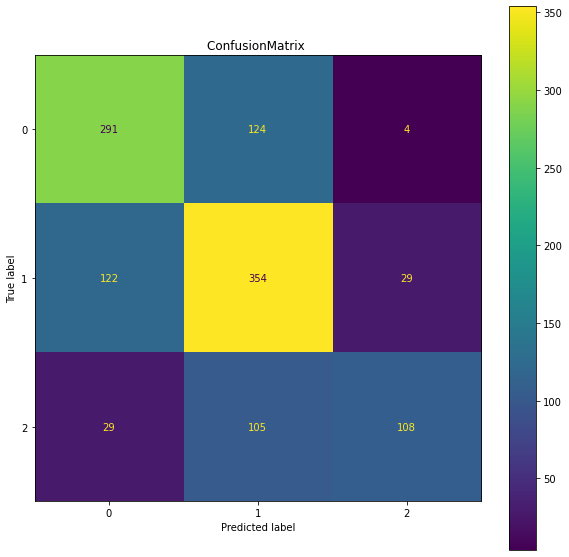

In [991]:
print("Точность:", (pred == label_test).mean())
plot_ConfusionMatrix(label_test, pred)

In [992]:
logRegr2 = LogisticRegression(lr = 0.01, epoch=40, batch_size=50)
svm2 = SVM(lr = 0.01, epoch=50, batch_size=5, alph=0.1)
knn2 = KNN(k = 10, countClasses=2)
knn2_2 = KNN(k = 5, countClasses=2)
bayes2 = NaiveBayes(lambd=1, countClasses=2)

hv2 = Hard_voting([logRegr2, knn2, knn2_2, svm2, bayes2])
hv2.fit(data_train2, label_train2)
pred2 = hv2.predict(data_test2)

Точность: 0.8782161234991424


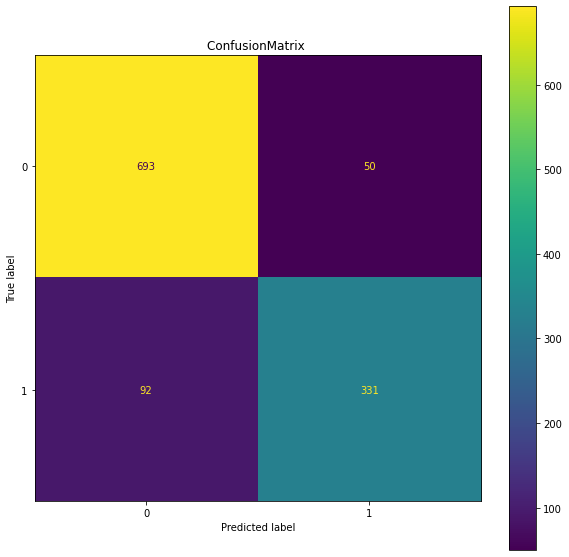

In [993]:
print("Точность:", (pred2 == label_test2).mean())
plot_ConfusionMatrix(label_test2, pred2)

Мягкое голосование

In [994]:
class Soft_voting:
    def __init__(self, algs):
        self.algs = algs

    def fit(self, data, labels):
        for f in self.algs:
            f.fit(data, labels)

    def predict(self, data):
        predictions = []
        for f in self.algs:
            predictions.append(f.pred_proba(data).T)
        answ = []
        pr = np.array(predictions).T
        
        for p in pr:
            pp = np.sum(p, axis=1)
            answ.append(np.argmax(pp))
        return answ 

In [ ]:
logRegr = LogisticRegressionMulti(lr = 0.01, epoch=80, batch_size=40, countClasses=3)
svm = SVM_Multi(lr = 0.001, epoch=20, batch_size=10, alph=0.1)
knn = KNN(k = 10, countClasses=3)
knn2 = KNN(k = 5, countClasses=3)
knn3 = KNN(k = 7, countClasses=3)
bayes = NaiveBayes(lambd=1, countClasses=3)

sv = Soft_voting([logRegr, knn, knn2, knn3, bayes])
sv.fit(data_train, label_train)
pred = sv.predict(data_test)

Точность: 0.6749571183533448


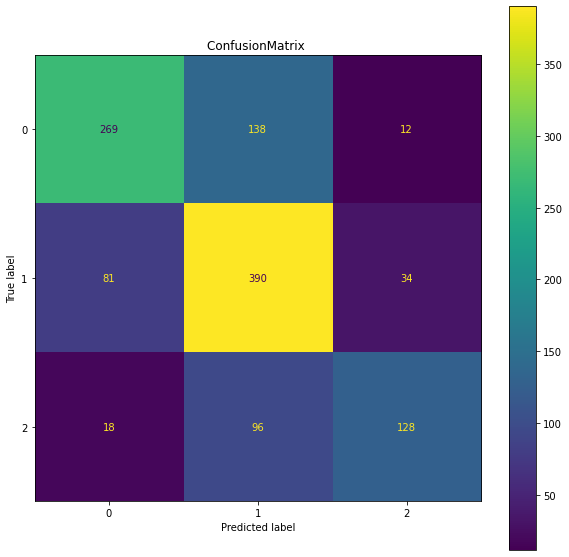

In [996]:
print("Точность:", (pred == label_test).mean())
plot_ConfusionMatrix(label_test, pred)

In [997]:
logRegr2 = LogisticRegression(lr = 0.01, epoch=40, batch_size=50)
svm2 = SVM(lr = 0.01, epoch=50, batch_size=5, alph=0.1)
knn2 = KNN(k = 10, countClasses=2)
knn2_2 = KNN(k = 5, countClasses=2)
bayes2 = NaiveBayes(lambd=1, countClasses=2)

sv2 = Soft_voting([knn2, knn2_2, bayes2])
sv2.fit(data_train2, label_train2)
pred2 = sv2.predict(data_test2)


[[0.26894142 0.70866083 0.26894142 ... 0.29133917 0.3208213  0.73105858]
 [0.73105858 0.29133917 0.73105858 ... 0.70866083 0.6791787  0.26894142]]
[[0.26894142 0.73105858 0.26894142 ... 0.3208213  0.41742979 0.73105858]
 [0.73105858 0.26894142 0.73105858 ... 0.6791787  0.58257021 0.26894142]]
[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


Точность: 0.8876500857632933


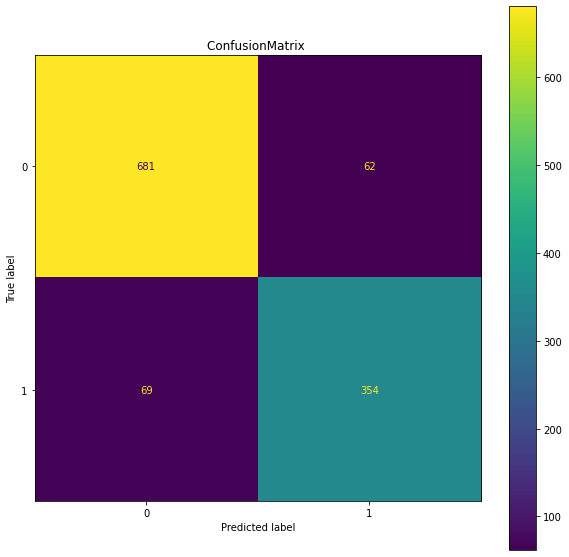

In [998]:
print("Точность:", (pred2 == label_test2).mean())
plot_ConfusionMatrix(label_test2, pred2)

Дерево решений

In [1031]:
class Node:
    def __init__(self, ind, val, end = False, ans = -1):
        self.ind = ind
        self.val = val
        self.end = end
        self.ans = ans
        self.l = -1
        self.r = -1

    def End(self):
        return self.end

class Tree:
    def __init__(self, depth, indexes = [] ,score = 0):
        self.max_depth = depth
        self.score = score
        self.indexes = []

    def gini_index(self, groups, classes):
        len_groups = [len(g) for g in groups]
        sum_len_gr = np.sum(len_groups)

        gini = 0.0
        for gr in groups:
            len_gr = len(gr)
            if len_gr == 0: continue
            score = 0.0
            clss = [el[-1] for el in gr]
            for class_val in classes:
                p = clss.count(class_val) / len_gr
                score += p * p
            gini += (1.0 - score) * (len_gr / sum_len_gr)
        return gini

    def split(self, index, value, data):
        left, right = list(), list()
        
        for elem in data:
            if elem[index] < value:
                left.append(elem)
            else:
                right.append(elem)
        return left, right

    def get_split(self, data):
        ind, val, score, groups = len(data[0]), np.max(data), 999, None

        if len(self.indexes) == 0:
            for i in range(len(data[0]) - 1):
                for elem in data:
                    groups = self.split(i, elem[i], data)
                    gini_score = self.gini_index(groups, self.classes)

                    if gini_score < score and len(groups[0]) > 0 and len(groups[1]) > 0:
                        ind, val, score, groups = i, elem[i], gini_score, groups
        else:
            for i in self.indexes:
                for elem in data:
                    groups = self.split(i, elem[i], data)
                    gini_score = self.gini_index(groups, self.classes)

                    if gini_score < score:
                        ind, val, score, groups = i, elem[i], gini_score, groups
        return ind, val, groups

    def Get_Ans(self, l, r):
        a1 = 0
        a2 = 1
        ll = Counter(np.array(l).T[-1]).most_common()
        rr = Counter(np.array(r).T[-1]).most_common()

        if ll[0][0] != rr[0][0]:
            a1 = ll[0][0]
            a2 = rr[0][0]
        else:
            if ll[0][1] > rr[0][1]:
                a1 = ll[0][0]
                a2 = 0 if a1 == 1 else 1
            else:
                a2 = rr[0][0]
                a1 = 0 if a1 == 1 else 1
        # print(a1, a2)
        return a1, a2

    def fit(self, data, label):
        self.nodes = {}

        self.classes = set(label)
        
        d = np.append(data.T, [label], axis = 0).T 
        
        ind, val, gr = self.get_split(d)
        
        self.nodes = {0: Node(ind, val)}

        a1, a2 = self.Get_Ans(gr[0], gr[1])

        self.build_node(0, 0, gr, 1, a1, a2)
    
    def fit_for_forest(self, data_and_lab):
        self.nodes = {}
        
        self.classes = set(data_and_lab.T[-1])
        
        ind, val, gr = self.get_split(data_and_lab)
        
        self.nodes = {0: Node(ind, val)}

        a1, a2 = self.Get_Ans(gr[0], gr[1])

        self.build_node(0, 0, gr, 1, a1, a2)

    def build_node(self, parent_num, num, gr, depth, ans_l, ans_r):
        l, r = gr
        temp_num = num + 1
        # print(temp_num)
        # print(f"len l = {len(l)} ")
        # print(f"len r = {len(r)} ")
        # print("parent = ", parent_num)
        # print("ans:", ans_l, ans_r)

        if len(l) == 0 or len(r) == 0:
            self.nodes[parent_num].end = True
            return parent_num + 1

        self.nodes[parent_num].l = temp_num
        if len(l) <= 1 or depth > self.max_depth:
            self.nodes[temp_num] = Node(-1, 0, True, ans_l)
            temp_num += 1
        else:
            ind_l, val_l, gr_l = self.get_split(l)
            self.nodes[temp_num] = Node(ind_l, val_l, False, ans_l)
            if len(gr_l[0]) > 0 and len(gr_l[1]) > 0:
                a1, a2 = self.Get_Ans(gr_l[0], gr_l[1])
            else:
                a1 = ans_l
                a2 = ans_r
            temp_num = self.build_node(temp_num, temp_num, gr_l, depth + 1, a1, a2)

        self.nodes[parent_num].r = temp_num
        if len(r) <= 1 or depth > self.max_depth:
            self.nodes[temp_num] = Node(-1, 0, True, ans_r)
        else:
            ind_r, val_r, gr_r = self.get_split(r)
            self.nodes[temp_num] = Node(ind_r, val_r, False, ans_r)
            if len(gr_r[0]) > 0 and len(gr_r[1]) > 0:
                a1, a2 = self.Get_Ans(gr_r[0], gr_r[1])
            else:
                a1 = ans_l
                a2 = ans_r
            temp_num = self.build_node(temp_num, temp_num, gr_r, depth + 1, a1, a2)
        
        return temp_num
    
    def Find(self, str, num):
        node = self.nodes[num]
        if node.End():
            return node.ans
        if str[node.ind] < node.val:
            return self.Find(str, node.l)
        return self.Find(str, node.r)
    
    def predict(self, data):
        rez = []
        for el in data:
            rez.append(abs(self.Find(el, 0)))
        return rez
        

In [ ]:
tr = Tree(5)
tr.fit(data_train2, label_train2)

Точность: 0.8001715265866209


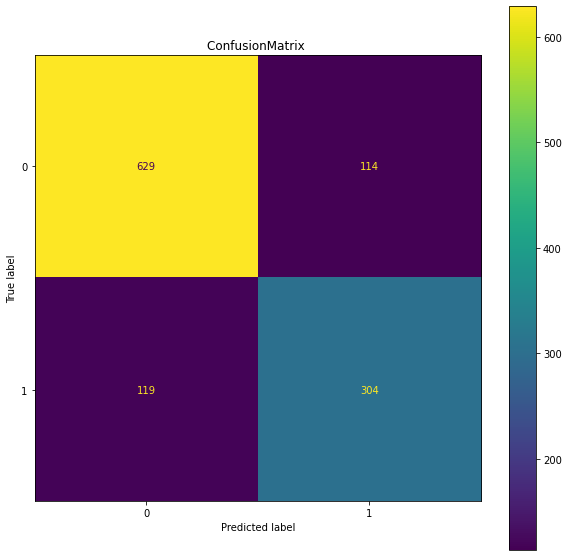

In [1033]:
pr = tr.predict(data_test2)

print("Точность:", (pr == label_test2).mean())

plot_ConfusionMatrix(label_test2, pr)

Случайный лес

In [1034]:
import random
def Rand_split(k, data):
    rez = [data, data[0: len(data) // 2], data[len(data) - len(data) // 2:]]
    for i in range(k - 3):
        start = random.randint(0, len(data))
        end = start
        while end == start or min(end, start) >= max(end, start) + 2:
            end = random.randint(0, len(data))
        d = data
        np.random.shuffle(d)
        rez.append(d[min(start, end):max(start, end)])
    return rez
    
def Rand_params(k, count):
    par = np.arange(0, count)
    np.random.shuffle(par)
    return list(par[:k])
    
class RandomForest:
    def __init__(self, k, depth):
        self.k = k
        self.depth = depth
    
    def fit(self, data, label):
        d = np.append(data.T, [label], axis = 0).T 

        rnd_data = Rand_split(self.k, d)
        rnd_params = [list(np.arange(0, len(data[0]) - 1))]
        for i in range(self.k - 1):
            count = random.randint(1, len(data[0]) - 2)
            rnd_p = Rand_params(count, len(data[0]) - 1)
            while rnd_params.count(rnd_p) > 0:
                count = random.randint(1, len(data[0]) - 2)
                rnd_p = Rand_params(count, len(data[0]) - 1)
            rnd_params.append(rnd_p)
        print(rnd_params)
        self.forest = []
        for i in range(self.k):
            tr = Tree(self.depth, rnd_params[i])
            tr.fit_for_forest(rnd_data[i])
            self.forest.append(tr)

    def predict(self, data):
        pr = []
        for i in range(self.k):
            p = self.forest[i].predict(data)
            pr.append(p)
        pr = np.array(pr).T
        rez = []
        for i in pr:
            rez.append(Counter(np.array(i)).most_common()[0][0])
        return rez

In [ ]:
rf = RandomForest(5, 5)
rf.fit(data_train2, label_train2)

Точность: 0.7101200686106347


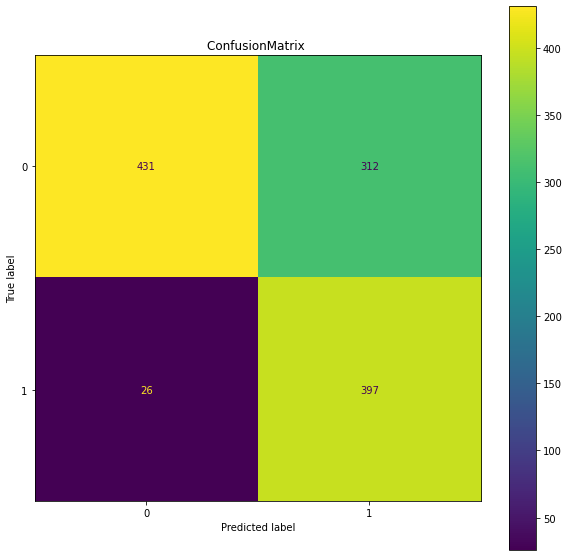

In [1042]:
pr = rf.predict(data_test2)
print("Точность:", (pr == label_test2).mean())

plot_ConfusionMatrix(label_test2, pr)

Градиентный бустинг

Точность: 0.9271012006861064


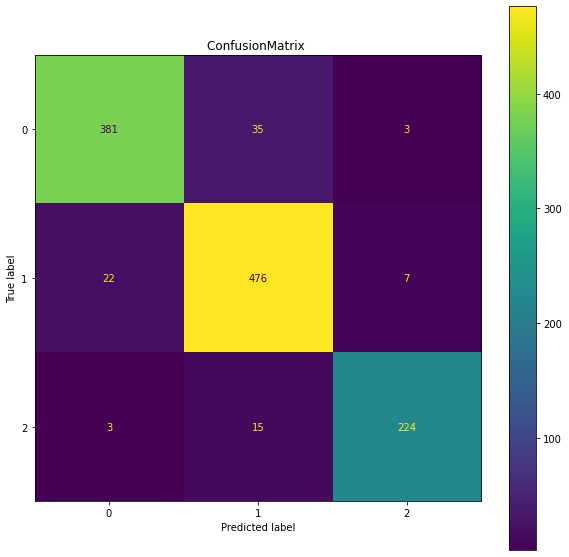

In [1005]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

gbr = HistGradientBoostingClassifier()
gbr.fit(data_train, label_train)

test_accuracy_score = gbr.score(data_test, label_test)
print("Точность:", test_accuracy_score)

pred = gbr.predict(data_test)

plot_ConfusionMatrix(label_test, pred)


Точность: 0.8902229845626072


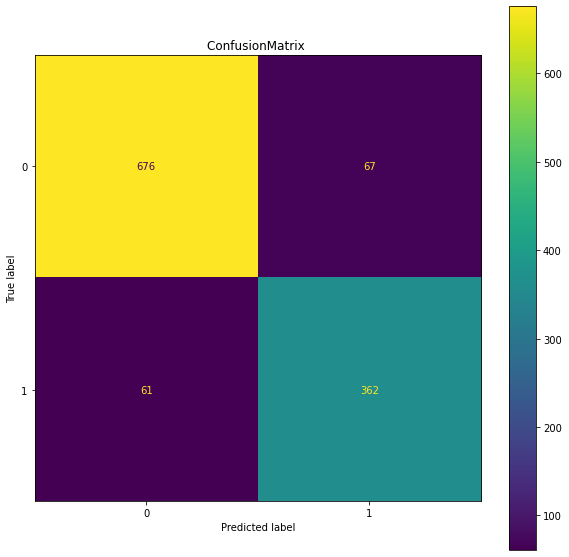

In [1006]:
gbr2 = GradientBoostingClassifier()
gbr2.fit(data_train2, label_train2)

test_accuracy_score2 = gbr2.score(data_test2, label_test2)
print("Точность:", test_accuracy_score2)

pred2 = gbr2.predict(data_test2)

plot_ConfusionMatrix(label_test2, pred2)